Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [2]:
NAME = "" # put your full name here
COLLABORATORS = [] # list anyone you collaborated with on this workbook

---

## Lab 7: Gradient Descent & Logistic Regression
**This lab was distributed the week of October 12, 2020 and should be completed by Tuesday, 10/20/2020 at 11:59PM.**

Welcome to the seventh lab of the semester!

In this lab, we'll introduce the concept of gradient descent. Then, we'll move on to solving classification problems using logistic regression.

### Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore', FutureWarning) # Seaborn triggers warnings in scipy
%matplotlib inline

In [4]:
# Configure nice plotting defaults - (this must be done in a cell separate from %matplotlib call)
plt.style.use('seaborn')
sns.set_context('talk', font_scale=1)
plt.rcParams['figure.figsize'] = (10, 6)

### Section 1: Gradient Descent

#### The Data

In this section, we'll try fitting a simple linear regression. The data we're using comes from [California's urban water suppliers](https://data.ca.gov/dataset/drinking-water-public-water-system-operations-monthly-water-production-and-conservation-information). Run the cell below to load the data to dataframe `df`.

In [5]:
df = pd.read_csv("data/uw_supplier_data100319.csv")
df.head()

,Supplier_Name,PWSID,Stage_Invoked,Mandatory_Restrictions,Reporting_Month,Production_Reported,2013_Production_Reported,CII_Reported,Agriculture_Reported,2013_Agriculture_Reported,...,Percent_Residential_Use,Comments_Corrections,Hydrologic_Region,Watering_Days_Per_Week,Complaints,Follow_Ups,Warnings,Penalties_Rate,Penalties_Other,Enforcement_Comments
0,East Bay Municipal Utilities District,CA0110005,0,NaN,2019-08-15,6459.2,7172.3,1362.2,NaN,NaN,...,61.0,No Correction,San Francisco Bay,7.0,0,0,0,0,0,Although EBMUD is not currently implementing i...
1,East Bay Municipal Utilities District,CA0110005,0,NaN,2019-07-15,6317.4,7452.2,1172.0,NaN,NaN,...,60.0,No Correction,San Francisco Bay,7.0,0,0,0,0,0,Although EBMUD is not currently implementing i...
2,East Bay Municipal Utilities District,CA0110005,0,NaN,2019-06-15,5880.6,6927.5,901.0,NaN,NaN,...,61.0,No Correction,San Francisco Bay,7.0,0,0,0,0,0,Although EBMUD is not currently implementing i...
3,East Bay Municipal Utilities District,CA0110005,0,NaN,2019-05-15,5203.6,6716.5,819.0,NaN,NaN,...,60.0,No Correction,San Francisco Bay,7.0,0,0,0,0,0,Although EBMUD is not currently implementing i...
4,East Bay Municipal Utilities District,CA0110005,0,NaN,2019-04-15,4465.1,5417.5,757.0,NaN,NaN,...,62.0,No Correction,San Francisco Bay,7.0,0,0,0,0,0,Although EBMUD is not currently implementing i...


This data provides monthly reports of water production from urban water suppliers in California. We'll see how well we can predict "Production_Calculated" (production for a given month from a given water supplier, standardized to units of gallons of water, from 2014-2019) based on "2013_Production_Calculated" (production for that same month in 2013 from the same water supplier, standardized to units of gallons of water). Run the cell below to see what this relationship looks like.

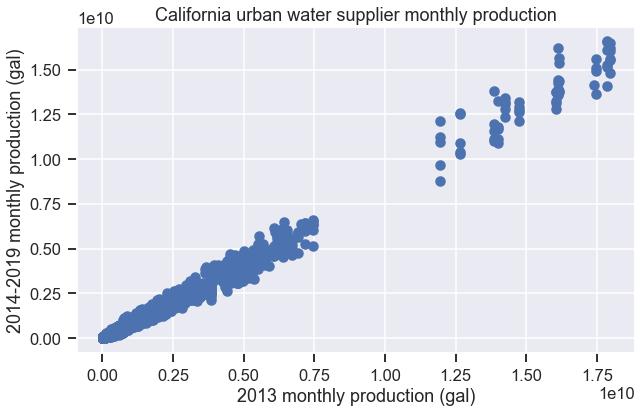

In [6]:
x = df["2013_Production_Calculated"]
y = df["Production_Calculated"]

plt.scatter(x,y)
plt.xlabel("2013 monthly production (gal)")
plt.ylabel("2014-2019 monthly production (gal)")
plt.title("California urban water supplier monthly production");

#### Absolute Loss (L1 Loss)

As we went over in lecture, the **mean absolute error** takes in the absolute difference between each point and the prediction. 

It is defined as:
$\begin{aligned}L&= \frac{1}{n} \sum_{i = 1}^{n} |y_i − \hat{y}| \\\end{aligned}$

Mean absolute error is known as L1 loss, and we will use those two terms interchangeably.

#### Question 1.1

Write `avg_abs_loss()` which takes in a set of predicted y values `y_hat` and a set of observed y values `y` and calculates mean absolute error  (hint: there's a numpy function you'll probably find pretty handy).

In [7]:
# SOLUTION
def avg_absolute_loss(y_hat, y):
    return np.mean(np.abs(y_hat-y))

Run the following cell and check to make sure the computation makes sense.

In [8]:
y_test = np.array([5, 7, 8, 9])
y_hat_test = np.array([6, 9, 7, 6])
assert avg_absolute_loss(y_hat_test, y_test) == 1.75

Let's visualize the L1 loss to get a better sense of what's happening. We're going to assume that the relationship between monthly production for 2013-2019 ($y$) and the monthly production for 2013 ($x$) can be described using a linear model, with the form $\hat{y} = \theta_0 + \theta_1*x$. We'll start with the assumption that $\theta_0 = 0$, then plot the mean absolute error for different values of $\theta_1$. In the cell below, we define a range for $\theta_1$, then calculate the L1 loss for each $\theta_1$ and plot the L1 loss vs. $\theta_1$.

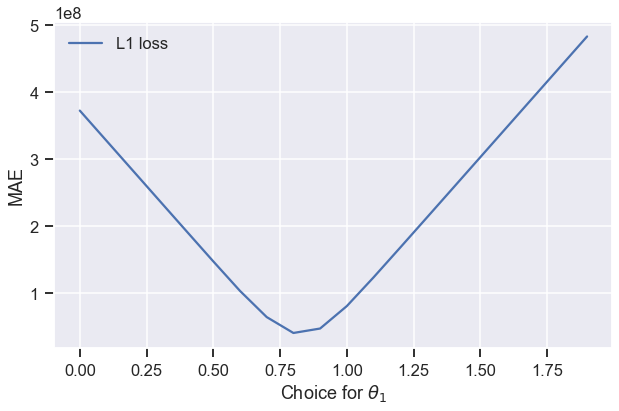

In [9]:
# Run this cell
theta_0 = 0
theta_1 = np.arange(0,2,0.1)

loss = np.full(len(theta_1),np.nan)


for i in range(len(theta_1)):
    y_hat = theta_0 + theta_1[i]*x
    loss[i] = avg_absolute_loss(y_hat,y)

# plot the loss
plt.plot(theta_1, loss, label="L1 loss")
plt.xlabel(r"Choice for $\theta_1$")
plt.ylabel(r"MAE")
plt.legend();

Based on the plot, what value of theta minimizes our loss?

_YOUR ANSWER HERE_

#### Gradient Descent

Sometimes, we cannot minimize loss functions analytically, especially when our models get more complex. And as we have seen in the asynchronous modules, brute force minimization by just trying out a bunch of different theta values and seeing which one returns the least loss is also incredibly inefficient. 

Instead, we use a technique called gradient descent, which is explained in [Ch.11 of the DS100 Textbook](https://www.textbook.ds100.org/ch/11/gradient_descent_define.html) and in Homework 7. To remind you of the intuition: the slope of the tangent line tells us which direction to move $\theta_1$ in order to decrease the loss. If the slope is negative, we want $\theta_1$ to move in the positive direction. If the slope is positive, $\theta_1$ should move in the negative direction. 

And mathematically, our formula is:

$$\theta^{(t+1)}_1 = \theta^{(t)}_1 − \alpha \cdot \frac{\partial}{\partial \theta_1} L(\theta^{(t)}_1, \textbf{y})$$

Where $ \theta^{(t)}_1$ is the current estimate, $ \theta^{(t+1)}_1$ is the next estimate, and $\alpha$ is the learning rate, or step size.


#### Question 1.2

Below is the partial derivative (gradient) of L1 loss. Using this formula, write a function that takes in a theta value and the observed data points, and returns the gradient of L1 loss at that theta. 

$$\begin{aligned}
\frac{\partial}{\partial \theta_1} L(\theta_1, \textbf{y})
&= \frac{1}{n} \left( \sum_{y_i < \theta_1*x_i}x_i - \sum_{y_i > \theta_1*x_i} x_i \right)\\
\end{aligned}$$

In [10]:
# SOLUTION
def grad_abs_loss(theta_1, x, y):
    x_greater = np.sum(x[x > (y/theta_1)])
    x_less = np.sum(x[x < (y/theta_1)])
    n = len(x)
    return (1/n)*(x_greater - x_less)

#### Question 1.3

Complete the function called `minimize`, which iteratively calculates $\theta$ until the values converge. In addition to $x$ and $y$, your function should take as input a loss function (e.g., the `avg_absolute_loss` you defined in Question 1.1).; a gradient loss function (e.g., the `grad_abs_loss` you defined in Question 3.1, and a value for $\alpha$. You only need to fill in the parts to find `new_theta` using the mathematical formula for gradient descent:

$$\theta^{(t+1)}_1 = \theta^{(t)}_1 − \alpha \cdot \frac{\partial}{\partial \theta_1} L(\theta_1^{(t)}, \textbf{y})$$

In [11]:
# SOLUTION
def minimize(loss_fn, grad_loss_fn, x,y, alpha=1e-10, progress=True):
    '''
    Uses gradient descent to minimize loss_fn. Returns the minimizing value of
    theta_hat.
    '''
    theta = 0
    loss = np.array([])
    while True:
        if progress:
            print(f'theta: {theta:.2f} | loss: {loss_fn(theta*x, y):.2f}')
        loss = np.append(loss, loss_fn(theta*x,y))
        gradient = grad_loss_fn(theta, x,y)
        new_theta = theta - alpha * gradient
        
        if len(loss) - len(np.unique(loss)) >= 10:
            return new_theta
        
        print('Number of iterations: {}'.format(len(loss)))
        
        theta = new_theta

**Question 1.4** 

What is the purpose of the code in Lines 16-17 of the `minimize` function?

`if len(loss) - len(np.unique(loss)) >= 10:
            return new_theta`

*YOUR ANSWER HERE*

**Solution:** Returns $\theta$ if the loop returns the same loss value ten or more times. This could occur if the theta has converged, or if theta is oscillating between the same values. 

**Question 1.5**

Run the following cell to see `minimize()` iteratively print each step in gradient descent and to find the minimizing theta for our small toy dataset.

In [12]:
# theta = minimize(avg_absolute_loss, grad_abs_loss, x,y)
# print(f'Minimizing theta: {theta}')
# print()

**Question 3.5** 

What happens to $ \hat {\theta}$ and the solve time (as indicated by number of iterations) if you set $\alpha$ equal to 1e-5? What about $\alpha$ = 1e-11?

In [13]:
# scratch work

theta = minimize(avg_absolute_loss, grad_abs_loss, x,y, alpha = 1e-5)
print(f'Minimizing theta: {theta}')
print()

theta: 0.00 | loss: 372559507.81
Number of iterations: 1
theta: 4503.70 | loss: 2027957679155.22
Number of iterations: 2
theta: 0.00 | loss: 372559507.81
Number of iterations: 3
theta: 4503.70 | loss: 2027957679155.22
Number of iterations: 4
theta: 0.00 | loss: 372559507.81
Number of iterations: 5
theta: 4503.70 | loss: 2027957679155.22
Number of iterations: 6
theta: 0.00 | loss: 372559507.81
Number of iterations: 7
theta: 4503.70 | loss: 2027957679155.22
Number of iterations: 8
theta: 0.00 | loss: 372559507.81
Number of iterations: 9
theta: 4503.70 | loss: 2027957679155.22
Number of iterations: 10
theta: 0.00 | loss: 372559507.81
Number of iterations: 11
theta: 4503.70 | loss: 2027957679155.22
Minimizing theta: 0.0



In [14]:
# scratch work

# theta = minimize(avg_absolute_loss, grad_abs_loss, x,y, alpha = 1e-11)
# print(f'Minimizing theta: {theta}')
# print()

*YOUR ANSWER HERE*

**Solution:** When you increase the size of alpha, the function fails to converge; theta oscillates between a very large value and zero. When you decrease the size of alpha, you get the correct answer for theta, but it takes a long time.

----

### Section 2: Logistic regression

In this lab, we'll do our first classification problem. With classification, we are working to predict response variables that are qualitative (i.e. categorical) rather than quantitative.

Some real-life examples of classification, from ISLR, are:
1. A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have?
1. An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user’s IP address, past transaction history, and so forth.
1. On the basis of DNA sequence data for a number of patients with and without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not.

Logistic regression is one method for solving classification problems.

### Theory

Let's start with the simple example of a modelling problem where the categorical variable can take on two values. For example, take a look at example #2 above - a bank needs to determine whether a transaction is fraudulent, so it is trying to model a situation with two potential values of the response variable: either the transaction was fraudulent (we'll give this category a value of Y = 1) or it was not (we'll give this category a value of Y = 0).

Since Y isn't a *continuous* variable - it can only take on a value of 0 or a value of 1, and these values don't represent any particular ordering - we use logistic regression, which models the *probability* that Y = 0 or Y = 1. We can write this probability as:

$ Pr(Y = 1|X)$ 

The expression above, in words, means "the probability that Y = 1 given X". In our case, Y = 1 means the transaction was fradulent, and X is the matrix of predictor variables (transaction history, IP address, etc) that we're using to predict Y. This probability expression can be written using the following shorthand:

$ Pr(Y = 1|X) = p(X)$ 

We *could* model this probability using a simple linear regression model, that would look something like this:

$p(X) = \beta_0 + \beta_1X_1$

As we'll see throughout the lab, however, simple linear regression doesn't really give us meaningful results when it comes to classification problems. Instead, logistic regression proposes a model that uses the logistic function, which looks something like this:

$p(X) = \frac{e^{\beta_0 + \beta_1X_1}}{1 + e^{\beta_0 + \beta_1X_1}}$

The two model forms above (linear and logistic regression) show the model form when we have one feature $X_1$, but can be easily extended to multiple features. The key to the logistic function is that it can only evaluate to values between 0 and 1, so it will always represent a probability.

Another important and related parameter is the **odds**. In statistics, the odds are defined as the probability of success over the probability of failure. If something is 50% likely to succeed, then its odds are 1 - there is an equal probability of success to failure. If it's 80% likely to succed, its odds are 0.8/(1-0.8) = 4 - there is a 4 to 1 chance of success to failure. The odds of $p(X)$ can be written as:

$\frac{p(X)}{1-p(X)}$

The odds of $p(X)$ can take any value between 0 and infinity. The logistic function can be re-written in the following way:

$log\left(\frac{p(X)}{1-p(X)}\right) = \beta_0 + \beta_1X_1$

This should look super familiar! It looks *almost* like a linear regression. Basically, we can represent the log-odds (also called the logit) as a function that is linear in $X_1$. It's important to be careful with interpretation here, though - even though the relationship between the logit and $X$ is linear, the relationship between $p(X)$ and $X$ is not. A unit increase in $X_1$ in the formula above represents an increase equal to $\beta_1$ in the *log-odds* of $p(X)$, which is the same as multiplying the odds by $e^{\beta_1}$. The amount that $p(X)$ changes when $X$ changes depends on the current value of $X$. However, there is a simple interpretation to the signs of the coefficients - if $\beta_1$ is positive, that means that an increase in $X_1$ leads to an increased probability of $p(X)$.

The basic intuition for how to choose the $\beta$ coefficients for logistic regression is similar to linear regression. With linear regression, we want to choose coefficients that make the prediction as close as possible to the observation $y$. With logistic regression, we want to choose coefficients that make the predicted probability (of, for example, a fraudulent transaction) as close as possible to the actual category of the transaction (1 for a fraudulent transaction, 0 for a non-fraudulent transaction). Logistic regression software functions work by maximizing something called the likelihood function, much like linear regression functions work by minimizing the mean squared error.

**(Optional) Challenge:** In the explanation above, we asserted that:

$log\left(\frac{p(X)}{1-p(X)}\right) = \beta_0 + \beta_1X_1$

Using a little bit of algebra, can you prove the claim above - that the logistic function representation is equivalent to logit representation for the logistic regression model? I.e., start with the logistic function:

$p(X) = \beta_0 + \beta_1X_1$

and solve for

$log\left(\frac{p(X)}{1-p(X)}\right)$

to get the logit representation above.

---
Now that we've gone through the basics, we can load our data and try implementing logistic regression.

In this section, we'll work with a modified version of the [ozone level detection dataset](https://archive.ics.uci.edu/ml/datasets/ozone+level+detection) from the UCI Machine Learning Repository, which uses temperature, wind speed, pressure, and other features to decide if a specific day was in fact a normal day or a high ground level ozone day. 

Run the cell below to load ozone.csv into dataframe `df`.

In [15]:
# run this cell
df = pd.read_csv('data/ozone.csv')
df.head()

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Class,intercept
0,4/30/1998,0.0,0.6,0.2,0.3,0.6,1.0,1.3,1.9,1.3,...,17.14,5.87,5745,16.40,43.50,10145,-10,0.0,1.0,1.0
1,5/12/1998,0.8,0.4,0.3,1.4,2.4,2.1,2.7,2.7,4.0,...,20.14,-4.56,5830,8.30,37.80,10095,-15,0.0,0.0,1.0
2,5/18/1998,0.0,0.2,0.0,0.5,0.1,0.4,0.5,0.6,1.3,...,5.38,-2.80,5935,5.70,36.40,10190,-10,0.0,1.0,1.0
3,5/29/1998,1.5,1.3,0.8,0.9,0.9,1.0,1.1,2.5,2.2,...,3.57,-2.00,5890,22.95,49.35,10140,5,0.0,1.0,1.0
4,8/1/1998,0.9,1.1,0.8,1.4,0.8,0.7,2.0,2.9,2.2,...,-4.96,-1.06,5965,23.20,42.40,10180,5,0.0,1.0,1.0


Looking at the columns, we can infer that columns WSR0, WSR1, etc. are the hourly measurements for the wind speed, and the second-to-last column, `Class`, is the variable we want to predict. 0 is a  normal day and 1 is an ozone day. If you want more information on the features, you can read up on the description of the data [here](https://archive.ics.uci.edu/ml/datasets/ozone+level+detection). 

**Question 2.1** Create a scatter plot showing `Class` versus `WSR_PK`. 

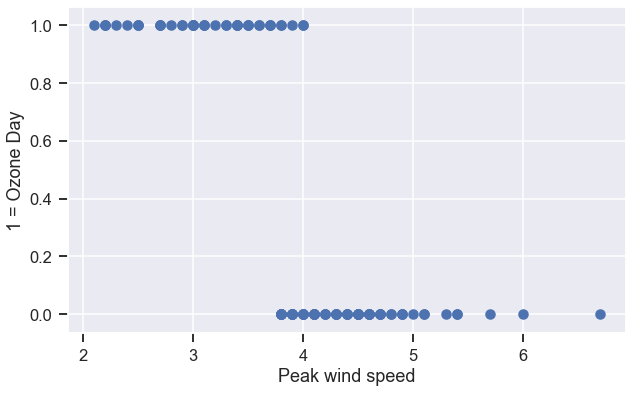

In [16]:
# barebones solution
plt.scatter(df.WSR_PK, df.Class)
plt.xlabel('Peak wind speed')
plt.ylabel('1 = Ozone Day');

**Question 2.2** Run the cell below to fit a linear regression to the data shown above. Based on the plot and your understanding of the data, why would linear regression be a poor choice for a predictive model in this case?

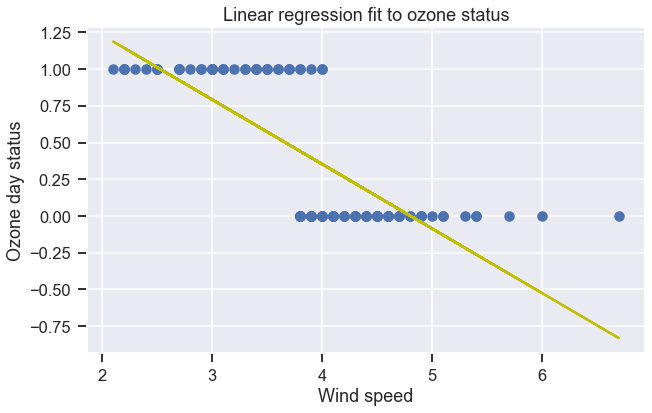

In [17]:
# run this cell
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(df[["WSR_PK"]], df[["Class"]])

plt.scatter(df.WSR_PK, df.Class)
plt.plot(df.WSR_PK, lm.predict(df[["WSR_PK"]]), c = "y")
plt.xlabel("Wind speed")
plt.ylabel("Ozone day status")
plt.title("Linear regression fit to ozone status");

*YOUR ANSWER HERE*

Let's try building a predictive model using classification! We'll build a logistic regression model with statsmodels. We'll use the [`Logit()` function](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html) function.

As an aside: we could also use scikit-learn's `LogisticRegression()` function, but scikit-learn performs logistic regression using a penalty by default, while statsmodel uses maximum likelihood estimation to choose coefficients. Both are useful depending on how you want to solve for your coefficients!

**Question 2.3** Run a logistic regression on the ozone dataset, using "Class" as the response variable and `WSR_PK` as the predictor. The code below gets you started. You may remember that statsmodels models require the `X` input to contain a column of ones to represent the intercept. Conveniently, the last column of our dataframe `df` is a column of ones called `intercept`. (If it didn't, we could use `np.ones()` to create a column of ones). Using the code below as a starting point, run a logistic regression that predicts `Class` given `WSR_PK` and `intercept`, and then print the parameters.

If you can't remember the general process for how to fit models with statsmodels, look back at Question 12 in Lab 6.

In [18]:
# solution
import statsmodels.api as sm

y = df.Class
X = df[['WSR_PK', 'intercept']]

logit = sm.Logit(y, X)
s = logit.fit()
s.params

Optimization terminated successfully.
         Current function value: 0.145107
         Iterations 10


WSR_PK      -11.711721
intercept    44.271185
dtype: float64

Let's use these weights (i.e. parameters or coefficients) shown above to plot predicted probabilities. To do that, we have to be able to calculate probability from the weights. Recall the relationship:
$$p(X) = \frac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}}$$

**Question 2.4** Write a function `prob_logit()` that returns a vector of probabilities p(X) given a vector of $\beta$ values and a matrix of $X$ values. The function `np.exp()` will be helpful here.

In [19]:
def prob_logit(params, X):
    """
    This function calculates the probability p(X) given a set of weights (params) and a matrix of X values.
    Arguments:
    params, a vector of weights from a logistic regression fit
    X, a matrix of predictor values with a number of columns equal to number of elements in params
    
    Returns:
    p, a vector of probabilities with the same length as the number of rows in X
    """
    
    x_weight = 0
    for param, col in zip(params, range(X.shape[1])):
        x_weight = x_weight + param*X.iloc[:,col]
    p = np.exp(x_weight)/(1+np.exp(x_weight))
    return p.values

In [20]:
s.params

WSR_PK      -11.711721
intercept    44.271185
dtype: float64

In [21]:
# check dimensions of output vector
assert(len(prob_logit(s.params, X)) == X.shape[0])

**Question 2.5** The `assert` block above checked the dimensions of your output. In the cell below, check that all the values in your output vector `p` are between 0 and 1 (inclusive) - i.e. we want to make sure that we're calculated a probability! If you find that your values are not all greater than or equal to 0 and less than or equal to 1, double check the calculation in `prob_logit()`.

In [22]:
# potential solution
p = prob_logit(s.params, X)
print((p >= 0).all())
print((p <= 1).all())

True
True


**Question 2.6** Now that we have our probabilities, we can plot our predictor variable (`WSR_PK`) vs our response variable (`CLASS`) with a curve representing the probability of an ozone day at each value of `WSR_PK` overlayed. Create that plot below - you will end up with a plot that looks like the one in 4.1, with a curve overlayed.

Note that to avoid a plot where `matplotlib` just connects the dots and you have lines all over the place, you'll have to pass a *sorted* version of `WSR_PK` to your function `prob_logit()`. Below, we've defined a variable `X_plot` that sorts the `WSR_PK` values that you can use as an input (assuming that you wrote `prob_logit()` to take a matrix `X` as input that contains features and the intercept; if you wrote `prob_logit()` to take a matrix without an intercept, you'll have to modify `X_plot`).

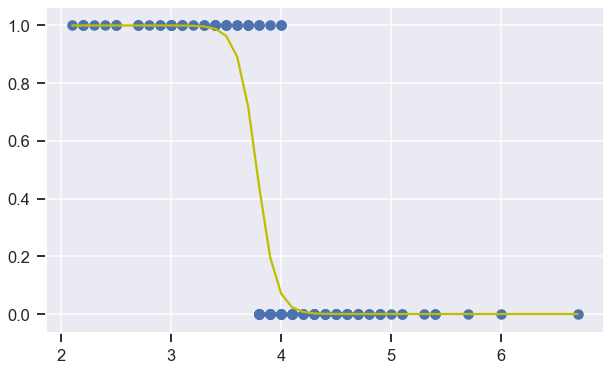

In [23]:
# SOLUTION
X_plot = df[['WSR_PK', 'intercept']].sort_values(by = 'WSR_PK')
plt.scatter(df.WSR_PK, df.Class);
plt.plot(X_plot['WSR_PK'], prob_logit(s.params, X_plot), c = 'y')

**Question 2.7** Visually, at what values of `WSR_PK` is our model pretty accurate? At what values of `WSR_PK` does it lose accuracy?

*YOUR ANSWER HERE*

Although we used only one feature for our regression, logistic regression also works with multiple features and is a powerful tool for classification. 


### Bibliography
- DS100 - “Gradient Descent” - https://www.textbook.ds100.org/ch/11/gradient_descent_define.html 
- DS100 - “Absolute Loss” - https://www.textbook.ds100.org/ch/10/modeling_abs_huber.html
- DS100 - “Models and Estimation” - http://www.ds100.org/fa18/assets/lectures/lec09/09-Models-and-Estimation-II.html 

---
Notebook developed by: Joshua Asuncion, Rebekah Tang. Edited by Jessica Katz.

Data Science Modules: http://data.berkeley.edu/education/modules
